## 1. Using Data Augmentation to increase dataset size

Data augmentation is a technique to increase the number of samples within the dataset by applying some transformations on the images (rotation, flipping, shearing,...etc).
<br>The code will change slightly using this technique, mainly for the model.fit function will change to model.fit_generator

Loading Training Samples...
0- [cats] with total of 4000 samples
1- [dogs] with total of 4000 samples
Loading Test Samples...
0- [cats] with total of 1000 samples
1- [dogs] with total of 1000 samples


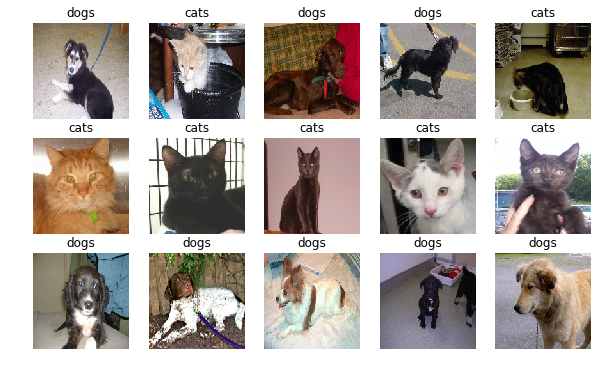

In [1]:
import numpy as np
import PML
import matplotlib.pyplot as plt
%matplotlib inline

TARGET_WIDTH=150
TARGET_HEIGHT=150

print("Loading Training Samples...")
samples,labels=PML.load_img_dataset_from_folder("datasets/catsdogs",target_size=(TARGET_WIDTH,TARGET_HEIGHT),grayscale=False)
#load test samples
print("Loading Test Samples...")
sample_test,labels_test=PML.load_img_dataset_from_folder("test/catsdogs/",target_size=(TARGET_WIDTH,TARGET_HEIGHT),grayscale=False)

PML.plot_random_images(samples,labels=labels,rows=3,cols=5)

In [2]:

from tensorflow.keras import utils
import random
import PML

#shuffle samples order
random.shuffle(samples)

#Split to input X and labels Y
X=np.array([i[0] for i in samples])
Y=np.array([i[1] for i in samples])

x_train=X
#prepare labels to one-hot-encoding
nb_classes=len(labels)
y_train = utils.to_categorical(Y, nb_classes)

In [3]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.1)

print("Training using: {0} samples".format(len(X_train)))
print("Validating using: {0} samples".format(len(X_test)))

Training using: 7200 samples
Validating using: 800 samples


Here we define the image data generator that will generate new images based on the parameters spcified.

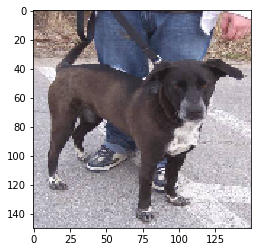

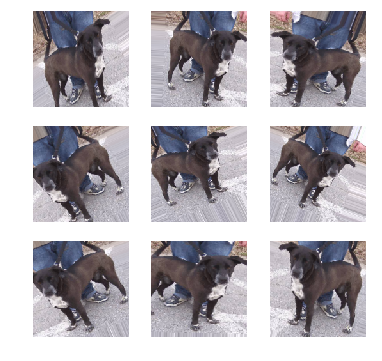

In [50]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen=ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                       height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                       horizontal_flip=True, fill_mode="nearest")

plt.imshow(image.array_to_img(X_train[0]))
plt.show()
#plot some random generated images
i=1
count=3
fig=plt.figure(figsize=(count*2,count*2))
for b in gen.flow(np.array([X_train[0]]),batch_size=1):
    fig.add_subplot(count,count,i)
    plt.axis('off')
    img=plt.imshow(image.array_to_img(b[0,:,:,:]))
    i+=1
    if(i>count*count):
        break
        
plt.show()

In [5]:
from tensorflow.keras.backend import set_session
import tensorflow as tf
conf=tf.ConfigProto()

conf.gpu_options.per_process_gpu_memory_fraction=0.9
conf.gpu_options.allow_growth=True
set_session(tf.Session(config=conf))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
__________

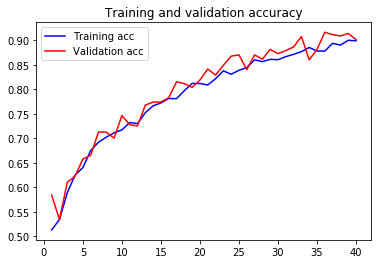

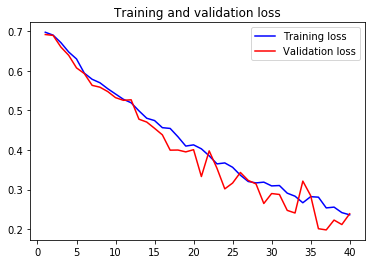

In [7]:

from tensorflow.keras.callbacks import TensorBoard
from time import time

input_shape=(TARGET_WIDTH,TARGET_HEIGHT,3)
BatchSize=64

model=PML.create_conv_classify_model(input_shape,nb_classes,32,[64,128,128],[256,64],dropout=0.2)

#instead of fitting on X_train,Y_train, we ask the generator to flow new images from the samples
if True:
    history=model.fit_generator(gen.flow(X_train,Y_train,batch_size=BatchSize),
                                validation_data=(X_test,Y_test),
                                epochs=40,
                                workers=16,
                                steps_per_epoch=len(X_train)//BatchSize)
else:
    history=model.fit(X_train,Y_train,
                        validation_data=(X_test,Y_test),
                        epochs=20,batch_size=BatchSize)

#export model
#PML.export_model(model,"./models/catsdogs")
PML.plot_acc_loss(history)

In [8]:
normalizer=PML.Normalizer01(0,1)
_=PML.test_samples(model,samples=sample_test,labels=labels,trainlabels=labels,normalizer=normalizer,flatten=False)

Accuracy for [cats] is 90%
Accuracy for [dogs] is 84%


Lets visualize what the model learnt

D:\Development\GitRepos\Teaching\PracticalML\6. Advance CNN\Python\PML.py:320: RuntimeWarning: invalid value encountered in true_divide
  channel_img/=channel_img.std()


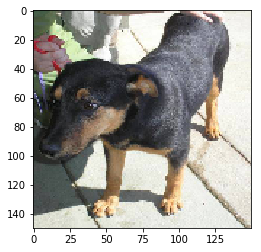

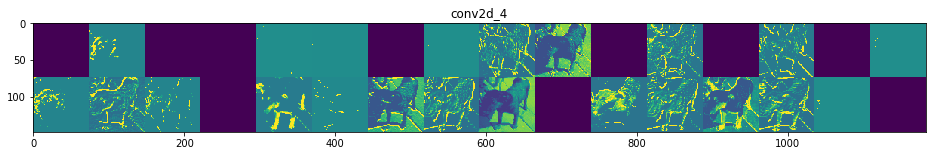

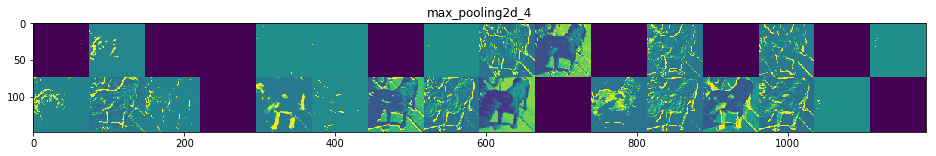

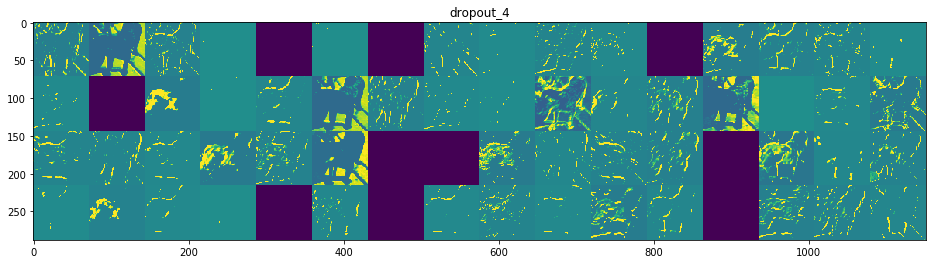

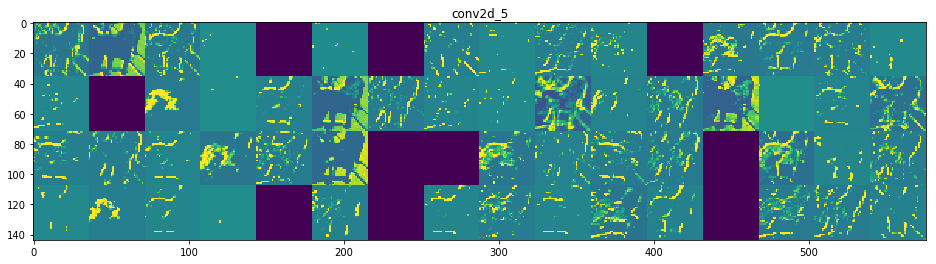

In [9]:
from importlib import reload  # Python 3.4+ only.
import PML

idx=2
plt.imshow(X_train[idx])
PML.VisualizeActivations(model,X_train[idx],5)

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
__________

In [33]:
from tensorflow.keras import backend as K
import numpy as np

def convert_image(x):
    x-=x.mean()
    x/=(x.std()+1e-5)
    x*=0.2
    
    x+=0.5
    x=np.clip(x,0,1)
    
    x*=255
    x=np.clip(x,0,255).astype('uint8')
    return x

def generate_pattern(model,layer_name,filter_index,size=224,step=1.,epochs=30):
    layer_output=model.get_layer(layer_name).output
    loss=K.mean(layer_output[:,:,:,filter_index])#loss function
    
    grads=K.gradients(loss,model.input)[0]#gradients
    
    norm_grads=grads/(K.sqrt(K.mean(K.square(grads)))+1e-5)#normalized gradients

    calc_function=K.function([model.input],[loss,norm_grads])#calculate loss and gradients with regard to model input
    
    input_img_data=np.random.random((1,size,size,3))*64+128
    
    #gradient descent
    for i in range(epochs):
        loss_val,grads_val=calc_function([input_img_data])
        input_img_data += grads_val*step
        
    return convert_image(input_img_data[0])

def VisualizeLayerActivation(model,layer_name,count=3,epochs=30,size=32,step=1):
    margin=5

    results=np.zeros((count*size+(count-1)*margin,count*size+(count-1)*margin,3))

    for i in range(count):
        for j in range(count):
            index=(j+(i*count))
            img=generate_pattern(model,layer_name,index,size=size,step=step,epochs=epochs)

            x=i*(size+margin)
            y=j*(size+margin)
            results[x:x+size,y:y+size,:]=img

    plt.figure(figsize=(10,10))
    plt.imshow(results.astype('uint8'))

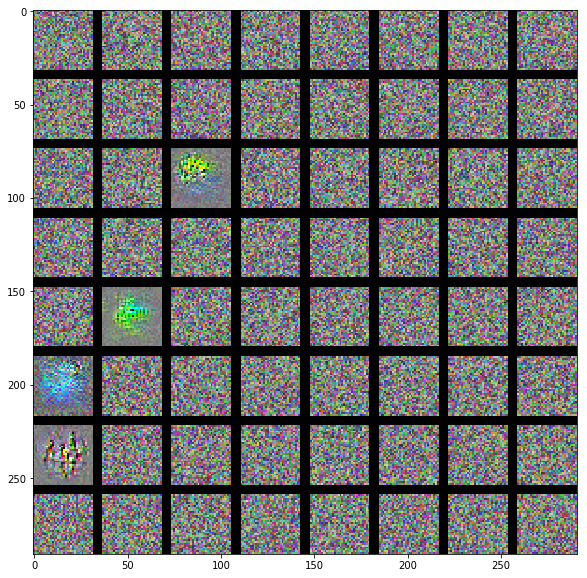

In [40]:
#VisualizeLayerActivation(model,'conv2d_4',count=3,epochs=30,step=2)
#VisualizeLayerActivation(model,'conv2d_5',count=3,epochs=30,step=2)
VisualizeLayerActivation(model,'conv2d_6',count=8,epochs=30,step=3)
#VisualizeLayerActivation(model,'conv2d_7',count=5,epochs=40)


## 2. Using pre-trained convnets

The second technique to facilitate the training accuracy is to use an existing trained model. We would only use the trained kernels, and add our own custom Dense layers on top. 

There are two ways to use pre-trained convnets to train our own models:
* __Feature Extraction__: Convert our training images into features using existing ConvNet, and these features then can be used as input to a second model we need to train. Advantage is training time really fast as no need to apply convolution every time on the training input, and only the dense network will be processed. Drawback is the difficulty to prepare and convert the inputs
* __Model Cascading__: Here we just add a dense network on top of the convnet. Here we must make the convnet as non-trainable or else the training time will be really really long. 

### 1- Feature Extraction:

In [41]:
#Loading the model.

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array

input_shape=(TARGET_WIDTH,TARGET_HEIGHT,3)
target_model='VGG16'

if(target_model=='VGG16'):
    #from tensorflow.keras.applications import VGG16
    from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
    #First time calling this will download the entire model (~500MB)
    conv_net=VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
elif (target_model=='InceptionV3'):
    #Inception model ~100MB
    from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
    conv_net=InceptionV3(weights='imagenet',include_top=False,input_shape=input_shape)

conv_net.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [44]:
BatchSize=64
nTrain=50*BatchSize
train_features=np.zeros(shape=(nTrain,4,4,512))
train_labels=np.zeros(shape=(nTrain,2))

i=0

for inputs_batch,labels_batch in gen.flow(X_train,Y_train,batch_size=BatchSize):
    feature_batch=conv_net.predict(inputs_batch)
    train_features[i*BatchSize:(i+1)*BatchSize]=feature_batch
    train_labels[i*BatchSize:(i+1)*BatchSize]=labels_batch
    i+=1
    if i*BatchSize>=nTrain:
        break

        
nVal=len(X_test)
validation_features=np.zeros(shape=(nVal,4,4,512))
validation_labels=np.zeros(shape=(nVal,2))
i=0
for inputs,label in zip(X_test,Y_test):
    features=conv_net.predict(np.array([inputs]))
    validation_features[i]=features[0]
    validation_labels[i]=label
    i+=1
        
train_features=np.reshape(train_features,(nTrain,4*4*512))
validation_features=np.reshape(validation_features,(nVal,4*4*512))

In [48]:
from tensorflow.keras import models,layers,optimizers

model=models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(2e-4),loss='categorical_crossentropy',metrics=['acc'])
model.summary()

history=model.fit(train_features,train_labels,
                  validation_data=(validation_features,validation_labels),
                  epochs=30,batch_size=BatchSize)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 514       
Total params: 2,097,922
Trainable params: 2,097,922
Non-trainable params: 0
_________________________________________________________________
Train on 3200 samples, validate on 800 samples
Epoch 1/30
3200/3200 [==============================] - 1s 361us/step - loss: 0.6417 - acc: 0.7156 - val_loss: 0.3632 - val_acc: 0.8075
Epoch 2/30
3200/3200 [==============================] - 1s 182us/step - loss: 0.3992 - acc: 0.8200 - val_loss: 0.2456 - val_acc: 0.9087
Epoch 3/30
3200/3200 [==============================] - 1s 173us/step - loss:

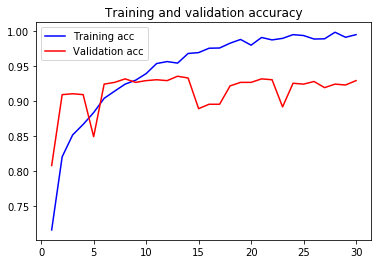

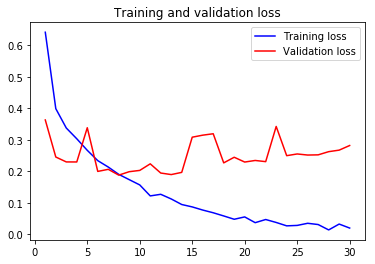

In [49]:
PML.plot_acc_loss(history)

### 3- Model Cascading


In [45]:
from tensorflow.keras import models,layers
from tensorflow.keras import models,layers,optimizers

model=models.Sequential()
model.add(conv_net)# <---- here we add the entire convnet model to create a cascaded models
model.add(layers.Flatten())#Flatten the last layer, so we can use our own dense layers
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 16,812,610
Trainable params: 2,097,922
Non-trainable params: 14,714,688
_________________________________________________________________


In [46]:
#Here we must freeze the conv_net so it does not train
print("[Before Freezing Conv_Net]: Total number of trainable weights: {0} weights".format(len(model.trainable_weights)))
conv_net.trainable=False
print("[After Freezing Conv_Net]: Total number of trainable weights: {0} weights".format(len(model.trainable_weights)))


[Before Freezing Conv_Net]: Total number of trainable weights: 4 weights
[After Freezing Conv_Net]: Total number of trainable weights: 4 weights


Epoch 1/40
50/50 [==============================] - 15s 301ms/step - loss: 0.4833 - acc: 0.7831 - val_loss: 0.3832 - val_acc: 0.8213
Epoch 2/40
50/50 [==============================] - 8s 160ms/step - loss: 0.3872 - acc: 0.8203 - val_loss: 0.5040 - val_acc: 0.7538
Epoch 3/40
50/50 [==============================] - 9s 177ms/step - loss: 0.3621 - acc: 0.8312 - val_loss: 0.2605 - val_acc: 0.8938
Epoch 4/40
50/50 [==============================] - 8s 162ms/step - loss: 0.3167 - acc: 0.8603 - val_loss: 0.3555 - val_acc: 0.8475
Epoch 5/40
50/50 [==============================] - 9s 177ms/step - loss: 0.3534 - acc: 0.8363 - val_loss: 0.2309 - val_acc: 0.9062
Epoch 6/40
50/50 [==============================] - 8s 161ms/step - loss: 0.3156 - acc: 0.8578 - val_loss: 0.2243 - val_acc: 0.9062
Epoch 7/40
50/50 [==============================] - 9s 176ms/step - loss: 0.3005 - acc: 0.8675 - val_loss: 0.2817 - val_acc: 0.8762
Epoch 8/40
50/50 [==============================] - 8s 161ms/step - loss: 0

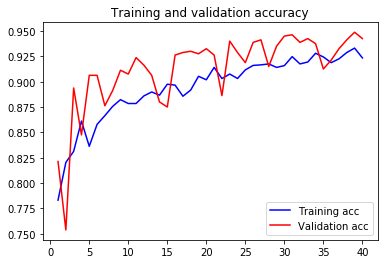

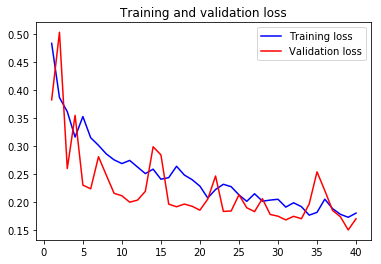

In [48]:

model.compile(optimizer=optimizers.RMSprop(2e-4),loss='categorical_crossentropy',metrics=['acc'])
history=model.fit_generator(gen.flow(X_train,Y_train,batch_size=BatchSize),
                    validation_data=(X_test,Y_test),
                    workers=16,
                    steps_per_epoch=50,epochs=40)
PML.plot_acc_loss(history)

In [49]:
normalizer=PML.Normalizer01(0,1)
_=PML.test_samples(model,samples=sample_test,labels=labels,trainlabels=labels,normalizer=normalizer,flatten=False)

Accuracy for [cats] is 95%
Accuracy for [dogs] is 87%
